In [2]:
#import torch
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import os
os.chdir('/home/lyz/co-phase-separation/PSGAT/')
DATA_ROOT = './data'

In [3]:
SAVE_ROOT = './saves/INTEGRATE_ProSE80d_pos1neg1/'
preds = pd.read_pickle(f'{SAVE_ROOT}preds.pkl')
genes = pd.read_pickle(f'{SAVE_ROOT}genes.pkl')

N = 10

In [5]:
phasepred_df = pd.read_pickle('./data/HUMAN_9606_PhaSePred_SaPS_PdPS.pkl')
entry2pdps_dict = phasepred_df.set_index('entry').to_dict()['PdPS-10fea']
entry2saps_dict = phasepred_df.set_index('entry').to_dict()['SaPS-10fea']

phasep_df = pd.read_pickle('./data/Label/human.condensate-formation.proteins-v1.pkl')
lt = set(phasep_df[phasep_df['source']=='literature']['uniprot_entry'])
pr = set(phasep_df[phasep_df['source']=='phasepred']['uniprot_entry'])
pr = pr - lt
dp = set(phasep_df[phasep_df['source']=='deepphase']['uniprot_entry'])
dp = dp - pr - lt

In [6]:
ppi = 'integrate'

ppi_path = os.path.join(
    DATA_ROOT,           
    f'PPIN/{ppi.upper()}.csv'
)
edges = pd.read_csv(ppi_path)
edges['C'] = np.sort(edges[['A', 'B']].values).sum(axis=1)

for i in range(N): 
    tmp = pd.read_pickle(f'{SAVE_ROOT}edge_cosine/model_{i}.pkl')
    edges[i] = tmp['cosim']
edges['pred'] = edges.iloc[:, 3:].mean(axis=1)

edges.loc[(edges['A'].isin(lt))&(edges['B'].isin(lt)), 'type'] = 'ps.ppi'
edges['type'] = edges['type'].fillna('nps.ppi')

In [7]:
for n in range(N):
    edges[['A', 'B', n]].to_csv(f'{SAVE_ROOT}edge_lists/weighted_{n}.txt', sep=' ', index=None, header=None)

edges[['A', 'B']].to_csv(f'{SAVE_ROOT}edge_lists/unweighted.txt', sep=' ', index=None, header=None)

edges[['A', 'B', 'pred']].to_csv(f'{SAVE_ROOT}edge_lists/weighted_average.txt', sep=' ', index=None, header=None)

In [ ]:
# import numpy as np
# import Cluster_Ensembles as CE
# 
# cluster_runs = np.random.randint(0, 50, (50, 15000))
# 
# cluster_runs
# 
# cluster_runs.shape
# 
# consensus_clustering_labels = CE.cluster_ensembles(cluster_runs, verbose=True, N_clusters_max=50)

# Ensemble clustering preprocess

In [19]:
from itertools import chain

def chainer(s, sep):
    return list(chain.from_iterable(s.str.split(sep)))

def split_items(dataframe, col_name, sep):
    lens = dataframe[col_name].str.split(sep).map(len)
    cols = dataframe.columns
    dict1 = {c: np.repeat(dataframe[c], lens) for c in cols}
    dict1[col_name] = chainer(dataframe[col_name], sep)
    return pd.DataFrame(dict1)

In [31]:
clusters = list()
for n in range(N):
    cl = pd.read_csv(f'./saves/INTEGRATE_ProSE80d_pos1neg1/clusterone_outputs/weighted_{n}.txt')
    clusters.append(cl)

In [ ]:
# cl = split_items(clusters[0], 'Members', ' ')[['Cluster', 'Members']]
# cl['Cluster'] = cl['Cluster'].apply(str)
# cl.groupby('Members')['Cluster'].apply(lambda x: ','.join(x))[25: 50]

# Evaluation
## Comparing with unweighted graph clustering results

In [8]:
pattern = '[OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2}'

import re
def find_entry(x):
    ls = x.split('|')
    entries = list()
    for i in ls:
        match = re.match(string=i, pattern=pattern)
        if match is None:
            continue
        else: 
            entries.append(match.group())
    return ';'.join(entries)

cplxprot_df = pd.read_table('/home/lyz/co-phase-separation/question1/data/9606.tsv')
cplxprot_df['subunits(UniProt IDs)'] = cplxprot_df['Identifiers (and stoichiometry) of molecules in complex'].apply(lambda x: find_entry(x))
cplxprot_df = cplxprot_df.rename(columns={'#Complex ac': 'ComplexID'})

code_df = pd.read_csv('/home/lyz/co-phase-separation/question1/data/download-data.csv')
code_df['subunits(UniProt IDs)'] = code_df['Proteins'].apply(lambda x: ';'.join(x.split('\t')))
code_df = code_df.rename(columns={'Name': 'ComplexID'})
code_9606_df = code_df[code_df['Species Name']=='Homo sapiens'].reset_index(drop=True)

In [10]:
ps_thre = .5
size_thre = 2

corum_df = pd.read_table('/home/lyz/co-phase-separation/question1/data/humanComplexes.txt')
corum_df = pd.concat([corum_df, cplxprot_df])
corum_df['size'] = corum_df['subunits(UniProt IDs)'].apply(lambda x: len(x.split(';')))
corum_df['ps.ratio'] = corum_df['subunits(UniProt IDs)'].apply(lambda x: len(set(x.split(';'))&lt)/len(x.split(';')))
corum_df = corum_df[(corum_df['size'] > size_thre) & (corum_df['ps.ratio'] >= ps_thre)].reset_index(drop=True)

In [11]:
def overlap_main(CL1, CL2):
    from itertools import product
    n1, n2 = [i for i in range(CL1.shape[0])], [j for j in range(CL2.shape[0])]
    clst_pairs = [m for m in product(n1, n2)]

    def calc_overlap(x1, idx2, sep1=';', sep2=' ', key=None):
        x2 = CL2['Members'][idx2]
        x1, x2 = set(x1.split(sep1)), set(x2.split(sep2))
        intersect = x1 & x2
        overlap = (len(intersect) ** 2) / (len(x1) * len(x2))
        if key==None:
            return overlap
        elif key=='intersect':
            return len(intersect)

    corum_mems = corum_df[['ComplexID', 'subunits(UniProt IDs)']].copy()
    confusion = corum_df[['ComplexID', 'subunits(UniProt IDs)']].copy()

    for idx in tqdm(n2):
        corum_mems[idx] = corum_mems['subunits(UniProt IDs)'].apply(lambda x: calc_overlap(x, idx))
        confusion[idx] = corum_mems['subunits(UniProt IDs)'].apply(lambda x: calc_overlap(x, idx, key='intersect'))

    max_overlaps = list()
    for _, i in tqdm(corum_mems.iterrows()):
        max_overlap = np.max(i.iloc[2:])
        max_overlaps.append(max_overlap)
    return confusion, max_overlaps

In [12]:
def combined_score(CL1, CL2):
    confu_matrix, CL1['max.os'] = overlap_main(CL1, CL2)
    mmr = CL1['max.os'].mean()
    frac_mat = CL1[CL1['max.os'] >= .25].shape[0] / CL1.shape[0]
    confu_matrix = confu_matrix.iloc[:, 2:].to_numpy()
    Sn = np.sum(np.max(confu_matrix, axis=1)) / CL1['size'].sum()
    PPV = np.sum(np.max(confu_matrix, axis=0)) / np.sum(confu_matrix)
    acc = np.sqrt(Sn * PPV)
    score = mmr + acc + frac_mat
    return mmr, acc, frac_mat, score

In [16]:
mmrs, accs, frac_mats, scores = [list() for i in range(4)]
for n in range(N):
    cl = pd.read_csv(f'{SAVE_ROOT}clusterone_outputs/weighted_{n}.txt')
    mmr_temp, acc_temp, frac_mat_temp, score_temp = combined_score(corum_df, cl)
    mmrs.append(mmr_temp)
    accs.append(acc_temp)
    frac_mats.append(frac_mat_temp)
    scores.append(score_temp)

cl_unw = pd.read_csv(f'{SAVE_ROOT}clusterone_outputs/unweighted_d03.txt')
mmr_unw, acc_unw, frac_mat_unw, score_unw = combined_score(corum_df, cl_unw)

cl_avg = pd.read_csv(f'{SAVE_ROOT}clusterone_outputs/weighted_average.txt')
mmr_avg, acc_avg, frac_mat_avg, score_avg = combined_score(corum_df, cl_avg)

  3%|▎         | 98/2992 [00:00<00:14, 197.56it/s]/home/lyz/anaconda3/envs/EPGAT/lib/python3.7/site-packages/ipykernel_launcher.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/home/lyz/anaconda3/envs/EPGAT/lib/python3.7/site-packages/ipykernel_launcher.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
100%|██████████| 2992/2992 [00:16<00:00, 184.20it/s]
252it [00:00, 700.33it/s]
100%|██████████| 3284/3284 [00:18<00:00, 180.88it/s]
252it [00:00, 758.04it/s]
100%|██████████| 3004/3004 [00:16<00:00, 180.82it/s]
252it [00:00,

In [18]:
stats = pd.DataFrame({
    'MMR': mmrs + [mmr_avg, mmr_unw],
    'Accuracy': accs + [acc_avg, acc_unw],
    'Frac.Match': frac_mats + [frac_mat_avg, frac_mat_unw],
    'Score': scores + [score_avg, score_unw],
    'Model': [n for n in range(N)] + ['average', 'unweighted']
})

In [19]:
stats

,MMR,Accuracy,Frac.Match,Score,Model
0,0.170003,0.415560,0.234127,0.819690,0
1,0.148522,0.406692,0.206349,0.761563,1
2,0.150810,0.413175,0.202381,0.766366,2
3,0.142641,0.432187,0.174603,0.749431,3
4,0.142114,0.422313,0.178571,0.742999,4
5,0.158813,0.414381,0.234127,0.807321,5
6,0.155514,0.425164,0.222222,0.802900,6
7,0.135884,0.406088,0.154762,0.696734,7
8,0.156412,0.412898,0.222222,0.791532,8
9,0.158947,0.399164,0.230159,0.788269,9


In [21]:
stats.to_pickle(f'{SAVE_ROOT}06-CORUM_and_MIPS_PS_score.pkl')

### Visualization

In [4]:
stats = pd.read_pickle(f'{SAVE_ROOT}06-CORUM_and_MIPS_PS_score.pkl')

In [5]:
stats_main = stats[(stats['Model']=='average') | (stats['Model']=='unweighted')]
stats_main

,MMR,Accuracy,Frac.Match,Score,Model
10,0.162438,0.398725,0.238095,0.799258,average
11,0.104519,0.417184,0.111111,0.632814,unweighted


In [6]:
stats_main_plot = []
for f in ['MMR','Frac.Match']:
    for m in ['average','unweighted']:
        stats_main_plot.append([f,m,stats_main[stats_main['Model']==m][f].tolist()[0]])
stats_main_plot = pd.DataFrame(stats_main_plot,columns=['param','model','value'])

In [8]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

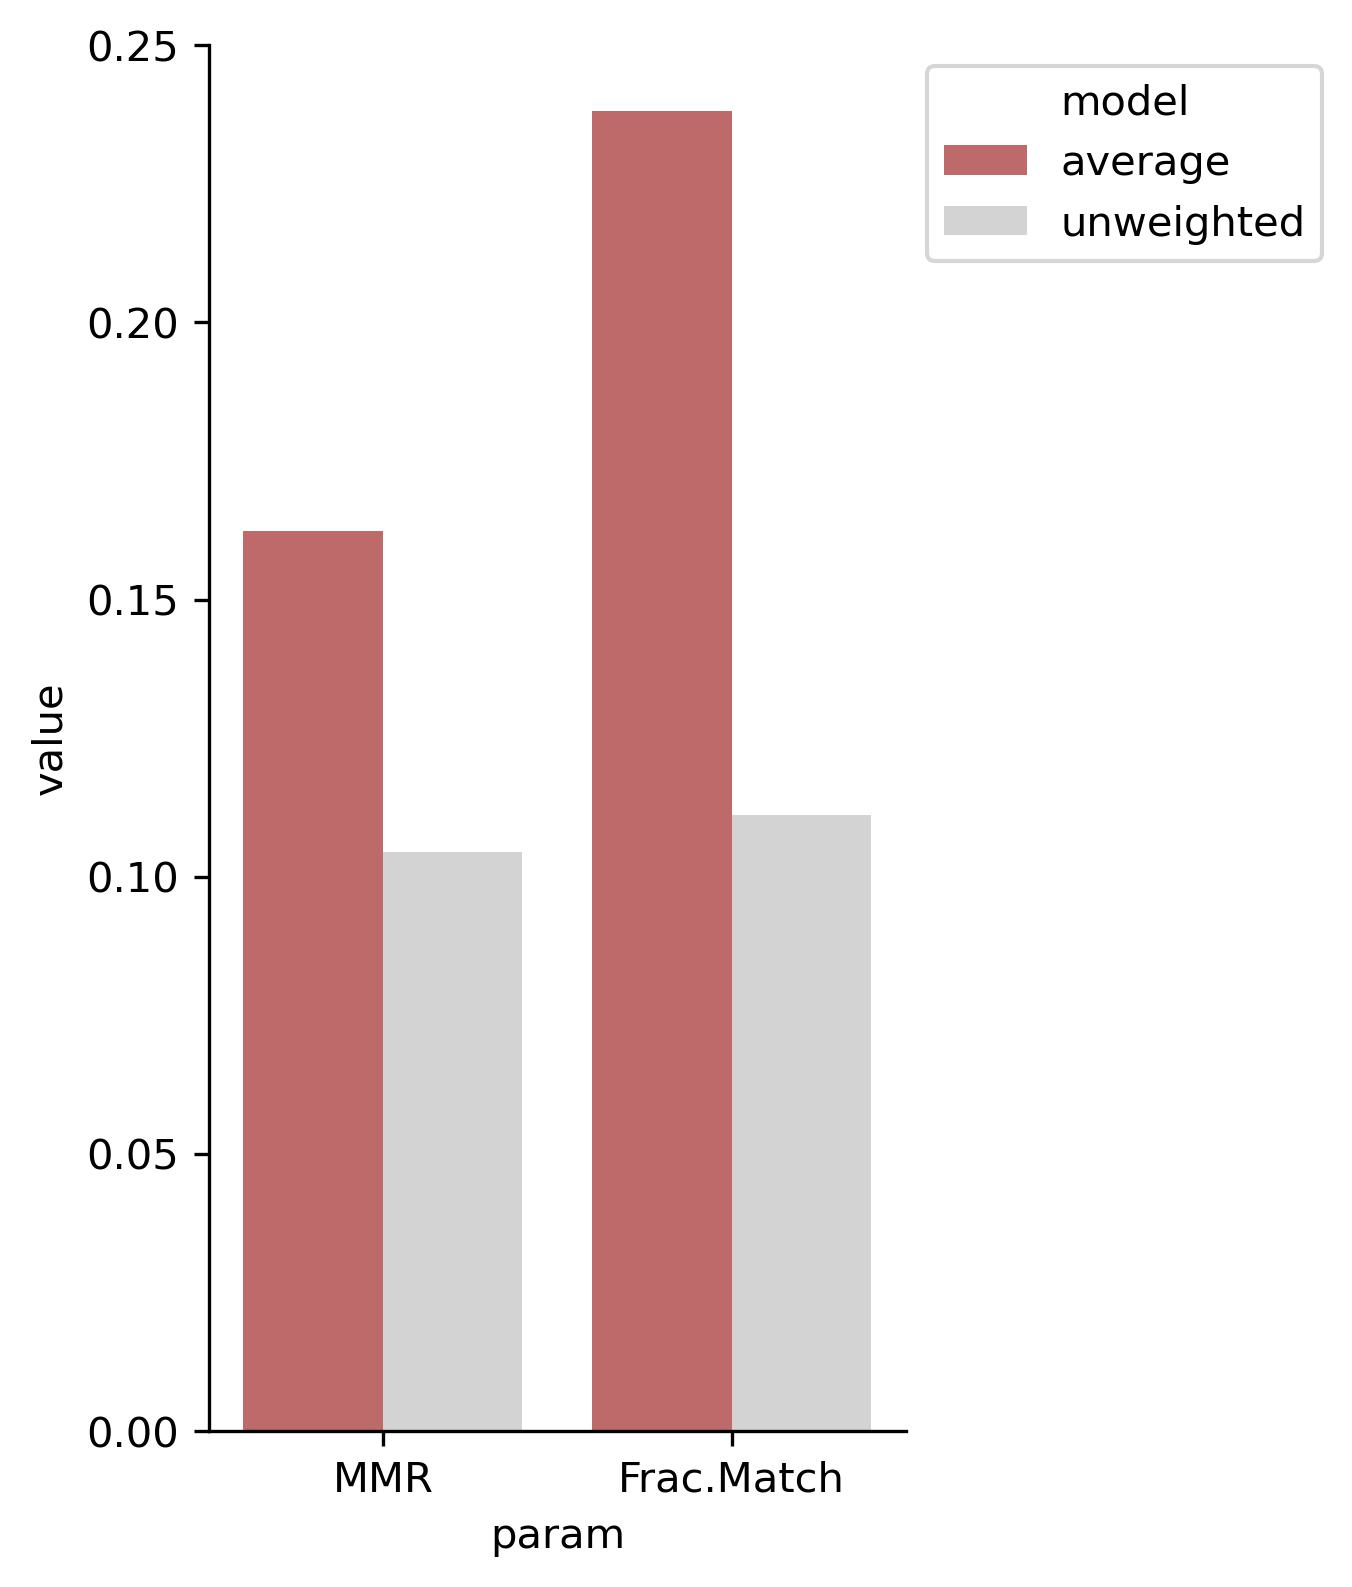

In [10]:
fig, ax = plt.subplots(
    figsize = (3, 6)
)
sns.barplot(data=stats_main_plot,x='param',y='value',hue='model',palette = {'average':'indianred','unweighted':'lightgrey'})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.savefig("Fig5B.png",bbox_inches='tight',dpi=500)

## MLOs enrichment in Pred Clusters

In [17]:
mlo_raw = pd.read_excel('./data/phasepdbv2_1_mlolt_mloht.xlsx')
mlo = mlo_raw[(mlo_raw['organism']=='Homo sapiens')&(mlo_raw['entry']!='_')].reset_index(drop=True)
mlo['entry'] = mlo['entry'].apply(lambda x: x.split('-')[0])
mloset = mlo.groupby('MLO')['entry'].apply(lambda x: ' '.join(set(x))).to_frame().reset_index()

In [18]:
mloset.head()

,MLO,entry
0,Cajal body,P19338 O00623 P61956 Q16637 Q92968 Q6NT76 Q96S...
1,"Cajal body,Nucleolus",O60832 P22087 O95453
2,Centrosome,Q99996
3,DNA damage foci,Q5UIP0
4,Histone locus body,Q9UKL3 Q14207 P49711


In [19]:
mloset['size'] = mloset['entry'].apply(lambda x: len(set(x.split(' '))))
mloset.sort_values(by='size', ascending=False).reset_index(drop=True)

,MLO,entry,size
0,Nucleolus,Q16778 O00168 P19622 P63096 Q9H3L4 Q96HI0 Q8N8...,2015
1,Stress granule,Q8N6H7 Q8NBM4 Q9NUQ6 Q92900 O76038 Q14576 Q9Y6...,1536
2,Nuclear stress body,P37802 B7Z972 F5H041 P42695 Q15233 Q5QPM1 Q142...,459
3,P-body,P0DOY2 Q96LI5 P52789 Q8WXI4 Q15233 Q92900 Q9UL...,397
4,Nuclear speckle,Q3ZCQ8 Q9H999 Q96QD9 Q8N4C6 Q9UKY1 Q9Y383 P570...,299
5,Paraspeckle,P61129 Q13561 Q969G3 Q99714 Q8N684 Q99729 Q8NC...,252
6,Splicesome,Q8TAD8 Q15427 Q12905 Q99729 Q9NZ63 Q16637 Q996...,246
7,Nuclear body,P30050 Q14974 Q86Y37 Q15427 P02304 Q15233 Q9UB...,174
8,PML nuclear body,O00623 Q7Z2Y5 Q14164 Q9NVV9 P61956 Q8IY18 Q9BW...,165
9,Cajal body,P19338 O00623 P61956 Q16637 Q92968 Q6NT76 Q96S...,120


### Overlap with unweighted clustering results

In [44]:
def calc_jaccard(x1, x2):
    jaccard = len(x1 & x2) / len(x1 | x2)
    return jaccard

In [41]:
cl = pd.read_csv(f'{SAVE_ROOT}clusterone_outputs/weighted_average.txt')
cl_unw = pd.read_csv(f'{SAVE_ROOT}clusterone_outputs/unweighted_d03.txt')

In [42]:
cl[cl['Members'].str.contains('P83916')]['Members'][1994]

'Q96KQ7 P83916 P45973 P23497 Q9H5I1 Q96JM2 P84243 Q6IQ32 O95785 Q9H9B1 Q9H582 O15054 Q9Y6F7'

In [45]:
# x1 = set(cl['Members'][0].split(' '))
# x2 = set(cl_unw['Members'][0].split(' '))
j_dict = dict()
for idx, m in tqdm(enumerate(cl['Members'])):
    x1 = set(m.split(' '))
    js = list()
    for n in cl_unw['Members']:
        x2 = set(n.split(' '))
        j = calc_jaccard(x1, x2)
        js.append(j)
    j_dict[idx] = js

2093it [00:11, 178.63it/s]


In [46]:
j_df = pd.DataFrame(j_dict)
cl['jaccard.with.unweight'] = [j_df.iloc[:, i].max() for i in range(j_df.shape[1])]

In [47]:
cl.head()

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members,jaccard.with.unweight
0,1,31,0.3021,140.50,758.1,0.14630,0.999874,Q9Y5B9 Q08945 Q96P70 Q9BTT0 P62805 Q01831 P499...,0.280702
1,2,18,0.3814,58.36,142.8,0.24600,0.556608,P49848 P21675 Q9HBM6 Q15545 Q15542 Q9BR10 Q155...,0.888889
2,3,24,0.2211,61.03,257.6,0.16650,0.991380,Q9HAH7 Q8IY57 Q86SE9 P61962 Q9BYE7 Q8N488 P783...,0.814815
3,4,9,0.3027,10.90,276.5,0.03569,0.999713,Q9UHE5 O95214 P54849 O15529 O15552 Q9HDC5 E9PQ...,0.125000
4,5,82,0.3011,999.90,5236.0,0.15620,0.958322,Q13586 P50402 P78310 Q8N144 Q96RD7 P51151 Q8WX...,0.034091


### Enrichment

In [19]:
# enrichment function used for MLOs and amin feature
def mlo_enrich(Member, Entry):
        members = Member.split(' ')
        entries = Entry.split(' ')
        a = set(members) & set(entries)
        b = set(members) - set(entries)
        c = set(entries) - set(members)
        d = set(genes) - set(members) | set(entries)
        frac = len(a) / len(members)
        from scipy.stats import fisher_exact
        _, pval = fisher_exact([[len(a), len(b)], [len(c), len(d)]])
        return frac, pval

In [ ]:
# enrichment function used for domains and motifs
def feature_enrich(Member, Entry):
        members0 = set(Member.split(' '))
        members1 = members0 & set(all_human_motifs['sequence_name'].tolist())
        members2 = members0 - set(all_human_motifs['sequence_name'].tolist())
        
        member1_uds = all_human_motifs.set_index(['sequence_name']).loc[list(members1),:]['uniprot_s'].tolist()
        members = list(members2)+member1_uds
        
        entries = Entry
        
        a = set(members) & set(entries)
        b = set(members) - set(entries)
        c = set(entries) - set(members)
        d = set(genes1) - set(members) | set(entries)
        frac = len(a) / len(members)
        from scipy.stats import fisher_exact
        _, pval = fisher_exact([[len(a), len(b)], [len(c), len(d)]])
        return frac, pval

In [ ]:
# mlo_enrich(cl['Members'][0], mloset['entry'][0])

In [20]:
# from collections import defaultdict
pvals, fracs = dict(), dict()
for _, row in tqdm(mloset.iterrows()):
    temp_ls1, temp_ls2 = list(), list()
    mlo, entry = row['MLO'], row['entry']
    for member in cl['Members']:
        f, p = mlo_enrich(member, entry)
        temp_ls1.append(p)
        temp_ls2.append(f)
    pvals[mlo] = temp_ls1
    fracs[mlo] = temp_ls2

23it [01:40,  4.38s/it]


In [21]:
fracs_df = pd.DataFrame(fracs)
cols = ['Frac ' + c for c in fracs_df.columns]
fracs_df.columns = cols

pvals_df = pd.DataFrame(pvals)
cols = ['FDR ' + c for c in pvals_df.columns]
pvals_df.columns = cols
# FDR correction
from statsmodels.stats.multitest import fdrcorrection
for c in pvals_df.columns:
    _, fdrs = fdrcorrection(pvals_df[c])
    pvals_df[c] = fdrs

enrich_df = pd.concat([cl, pvals_df, fracs_df], axis=1)

In [23]:
# enrich_df.to_pickle(f'{SAVE_ROOT}06-Cluster_FDR_and_Frac.pkl')

### Selecting weight-specific LLPS condensates

In [32]:
enrich_df = pd.read_pickle(f'{SAVE_ROOT}/06-Cluster_FDR_and_Frac.pkl')

In [15]:
enrich_df.head()

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members,jaccard.with.unweight,FDR Cajal body,...,"Frac PML nuclear body,Nucleolus",Frac Paraspeckle,Frac Polycomb body,Frac Postsynaptic density,Frac SMN complex,Frac Sam68 nuclear body,Frac Spindle apparatus,Frac Splicesome,Frac Stress granule,Frac Viroplasm
0,1,31,0.3021,140.50,758.1,0.14630,0.999874,Q9Y5B9 Q08945 Q96P70 Q9BTT0 P62805 Q01831 P499...,0.280702,1.0,...,0.0,0.000000,0.000000,0.0,0.032258,0.0,0.0,0.0,0.193548,0.0
1,2,18,0.3814,58.36,142.8,0.24600,0.556608,P49848 P21675 Q9HBM6 Q15545 Q15542 Q9BR10 Q155...,0.888889,1.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.055556,0.0
2,3,24,0.2211,61.03,257.6,0.16650,0.991380,Q9HAH7 Q8IY57 Q86SE9 P61962 Q9BYE7 Q8N488 P783...,0.814815,1.0,...,0.0,0.000000,0.041667,0.0,0.000000,0.0,0.0,0.0,0.041667,0.0
3,4,9,0.3027,10.90,276.5,0.03569,0.999713,Q9UHE5 O95214 P54849 O15529 O15552 Q9HDC5 E9PQ...,0.125000,1.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,5,82,0.3011,999.90,5236.0,0.15620,0.958322,Q13586 P50402 P78310 Q8N144 Q96RD7 P51151 Q8WX...,0.034091,1.0,...,0.0,0.012195,0.000000,0.0,0.000000,0.0,0.0,0.0,0.256098,0.0


In [33]:
enrich_cls_05, enrich_cls_01 = list(), list()
enrich_mlos_05, enrich_mlos_01 = list(), list()
p_threshold = .05
for m in mloset['MLO'].tolist():
    enrich_ls = enrich_df[enrich_df[f'FDR {m}'] < p_threshold]['Cluster'].tolist()
    if len(enrich_ls)!=0:
        enrich_mlos_01.append(m)
    enrich_cls_01.extend(enrich_ls)

In [34]:
clt2x_dict = dict(zip(sorted(list(set(enrich_cls_01))), [i for i in range(len(set(enrich_cls_01)))]))
mlo2y_dict = dict(zip(enrich_mlos_01, [i+1 for i in range(len(set(enrich_mlos_01)))]))
clt2size_dict = cl.set_index('Cluster').to_dict()['Size']

In [48]:
def cl_entry(x, feat='PdPS-10fea'):
    ls = x.split(' ')
    df = pd.DataFrame(ls)
    df['PdPS-10fea'] = df[0].map(entry2pdps_dict)
    df['SaPS-10fea'] = df[0].map(entry2saps_dict)
    e = df[df[feat]==df[feat].max()][0].item()
    return e

cl_entries = cl['Members'].apply(lambda x: cl_entry(x))
cl['Entry'] = cl_entries

In [24]:
# cl_entries.to_csv(f'{SAVE_ROOT}06-Cluster_Entry.txt', index=None, header=None)

In [49]:
cl_names = pd.read_table(f'{SAVE_ROOT}06-Cluster_Entry_GeneName.tsv')
cl_names['gene.name'] = cl_names['Gene Names'].apply(lambda x: x.split(' ')[0])
entry2name_dict = cl_names.set_index('Entry').to_dict()['gene.name']

In [50]:
cl['mean_SaPS'] = [np.mean([entry2saps_dict[k] for k in i.split(' ')]) for i in cl['Members'].tolist()]
cl['mean_PdPS'] = [np.mean([entry2pdps_dict[k] for k in i.split(' ')]) for i in cl['Members'].tolist()]

In [51]:
cl['Gene Name'] = cl['Entry'].map(entry2name_dict)

In [52]:
cl_sig = cl[(cl['mean_PdPS']>0.5) | (cl['mean_SaPS']>0.5)]
cl_sig = cl_sig[cl_sig['Size']>=5]

In [53]:
cl_sig

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members,jaccard.with.unweight,Entry,mean_SaPS,mean_PdPS,Gene Name
0,1,31,0.3021,140.500,758.10,0.14630,0.999874,Q9Y5B9 Q08945 Q96P70 Q9BTT0 P62805 Q01831 P499...,0.280702,Q08945,0.378145,0.543313,SSRP1
2,3,24,0.2211,61.030,257.60,0.16650,0.991380,Q9HAH7 Q8IY57 Q86SE9 P61962 Q9BYE7 Q8N488 P783...,0.814815,Q8IY57,0.451542,0.535460,YAF2
10,11,5,0.3023,3.023,145.90,0.01902,0.996692,Q68G74 Q9NU19 Q8TF47 Q9H3P7 Q8WUA7,0.222222,Q9H3P7,0.330681,0.531021,ACBD3
12,13,6,0.3067,4.600,108.10,0.03690,0.998474,Q01484 Q8IXS6 Q9UQF2 Q12955 Q14679 Q92565,0.363636,Q9UQF2,0.580828,0.511233,MAPK8IP1
14,15,18,0.3009,46.030,360.80,0.10390,0.996246,P48426 Q15059 Q8N3E9 Q8TBX8 Q96JC9 P42568 Q9UH...,0.379310,Q03111,0.518144,0.613088,MLLT1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,2078,6,0.3188,4.783,86.66,0.04624,0.967224,P35611 Q8N6D5 Q9UEY8 P35612 P32456 Q5JUQ0,0.300000,P35611,0.427411,0.515261,ADD1
2078,2079,12,0.3006,19.840,274.80,0.06225,0.999761,Q86V42 Q9HAP6 Q8N3R9 Q9Y2J4 P35580 Q8IY63 P469...,0.500000,Q8IY63,0.420665,0.588622,AMOTL1
2081,2082,32,0.3011,149.300,2772.00,0.05002,1.000000,Q96A22 Q03135 P78310 O75955 P06239 P07948 P299...,0.051282,Q8TEW0,0.536766,0.634014,PARD3
2084,2085,8,0.3072,8.602,361.90,0.02226,0.994959,Q9BRX9 Q9UDY2 Q86UK7 Q9BRR8 O75420 O60573 Q6Y7...,0.153846,Q9UDY2,0.430466,0.502686,TJP2


In [54]:
len(cl_sig)

288

In [56]:
cl_sig.index=range(len(cl_sig))

In [57]:
already = []
labels = []
for i in tqdm(range(len(cl_sig))):
    entry = cl_sig.loc[i,'Gene Name']
    count = cl_sig.loc[i,'Size']
    if entry not in already:
        label = f"{entry}({count})"
        already.append(entry)
        labels.append(label)
    else:
        label = f"{entry}_{already.count(entry)}({count})"
        already.append(entry)
        labels.append(label)

100%|██████████| 288/288 [00:00<00:00, 47984.41it/s]


In [59]:
cl_sig['Label'] = labels

In [60]:
#cl_sig.to_pickle(f"{SAVE_ROOT}06-Cluster_LLPS-related.pkl")